In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from glob import glob
import os
import TOC_functions
from scipy.stats import linregress
%matplotlib widget 

In [2]:
root_folder = os.path.expanduser('C:/Users/ica/OneDrive - Plymouth Marine Laboratory/vscode/TOC_analysis/data/11')  # yourpath
picarro_df = TOC_functions.merge_picarro_files(root_folder)
picarro_df.set_index('datetime', inplace=True)

In [3]:
# filter by time

start_time = datetime.datetime(2024, 11, 27, 10, 0, 0)
end_time = datetime.datetime(2024, 11, 28, 12, 0, 0)

In [ ]:
df = picarro_df.loc[start_time:end_time]
df = TOC_functions.qc(df)

In [5]:
TOC_df = TOC_functions.TOC_df(df)


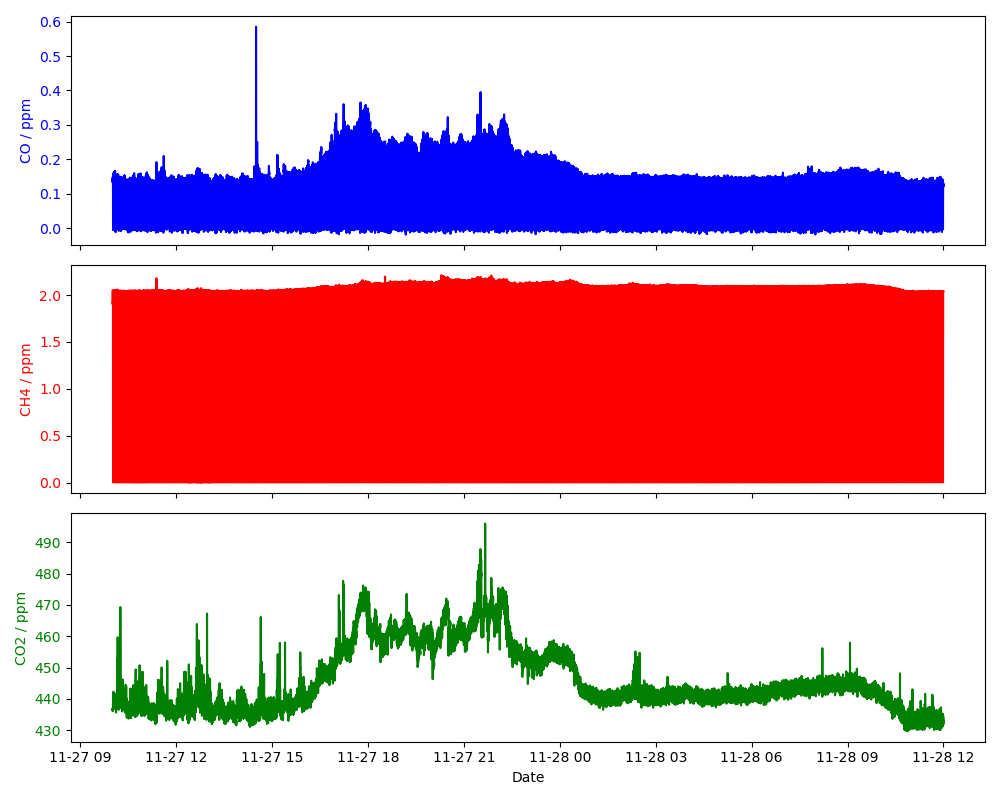

In [6]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, sharex=True, figsize=(10, 8))

# Plot for CO
ax1.plot(df.index, df.CO, label='CO / ppm', color='blue')
ax1.set_ylabel('CO / ppm', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Plot for CH4
ax2.plot(df.index, df.CH4_corrected, label='CH4 / ppm', color='red')
ax2.set_ylabel('CH4 / ppm', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Plot for CO2
ax3.plot(df.index, df.CO2_corrected, label='CO2 / ppm', color='green')
ax3.set_xlabel('Date')
ax3.set_ylabel('CO2 / ppm', color='green')
ax3.tick_params(axis='y', labelcolor='green')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [24]:
def calculate_ox(TOC_df):
    ch4_ox = []

    for i in range(0, len(TOC_df)-1, 2):
        pair = TOC_df.iloc[i:i+2]

        ch4_catalyst = pair['avg_ch4_catalyst'].sum()
        ch4_ambient = pair['avg_ch4_ambient'].sum()
        # Calculate CH4 oxidation
        ch4_ox_value = 1 - (ch4_catalyst / ch4_ambient)
        
        # Use the mean timestamp of the pair
        ch4_ox.append((pair.index.mean(), ch4_ox_value))
    return pd.DataFrame(ch4_ox, columns=['datetime', 'ch4_ox']).set_index('datetime')
    
   

In [25]:
ch4_ox_df_resampled = (
    calculate_ox(TOC_df)
    .resample('1T').mean()
    .assign(H2O=df.resample('1T').mean()['H2O'])
    .replace(-np.inf, np.nan)
    .dropna()
)

C:\Users\ica\AppData\Local\Temp\ipykernel_18520\2167363650.py:10: RuntimeWarning: divide by zero encountered in scalar divide
  ch4_ox_value = 1 - (ch4_catalyst / ch4_ambient)
C:\Users\ica\AppData\Local\Temp\ipykernel_18520\2576984097.py:3: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  .resample('1T').mean()
C:\Users\ica\AppData\Local\Temp\ipykernel_18520\2576984097.py:4: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  .assign(H2O=df.resample('1T').mean()['H2O'])


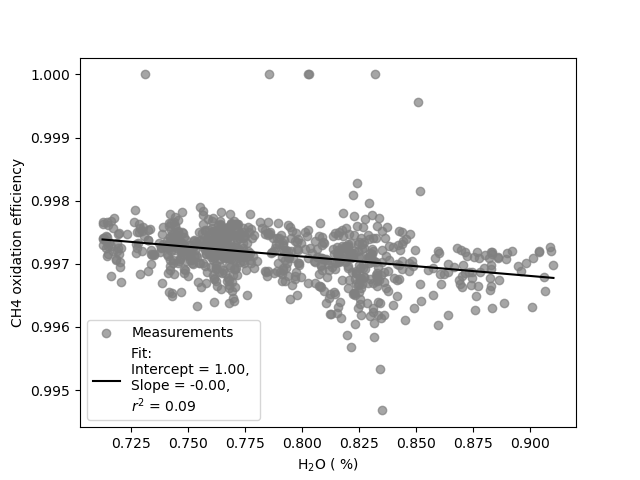

In [27]:

# Extract x and y values after dropping NaNs
x = ch4_ox_df_resampled.H2O
y = ch4_ox_df_resampled.ch4_ox

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Generate the fitted line
x_fit = np.linspace(x.min(), x.max(), 100)
y_fit = slope * x_fit + intercept

# Plot the data and the fitted line
plt.figure()
plt.scatter(x, y, label='Measurements', color='gray', alpha=0.7)
plt.plot(x_fit, y_fit, label=f'Fit: \nIntercept = {intercept:.2f}, \nSlope = {slope:.2f}, \n$r^2$ = {r_value**2:.2f}', color='black')
plt.xlabel('H$_2$O ( %)')
plt.ylabel('CH4 oxidation efficiency')
plt.legend(loc='best')
plt.show()
